<a href="https://colab.research.google.com/github/vijaykeshri/Learning/blob/develop/fine-tune/Mistral7bMetQLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***fine-tuning*** takes much less data and computation compared to the previous pre-trained/foundation model but it’s still not possible on consumer-grade hardware.

**PEFT(parameter efficient fine-tuning)** fixes this issue and applies clever methods to make fine-tuning possible even on the free tier of Google Colab.

Lets use **Quantization** and **LoRA**(Low-Rank Adaptation) to fine-tune Mistral 7b instruct and introduce new knowledge to it.

**LoRA** freezes the model's parameters(W0), attaches small *trainable adapter layers(ΔW = BA) to it, and only trains the adapter*. this reduces the trainable parameters by a lot and consumes much less RAM. One important hyperparameter in LoRA is the r, in this example r=2.![GneralQ.png](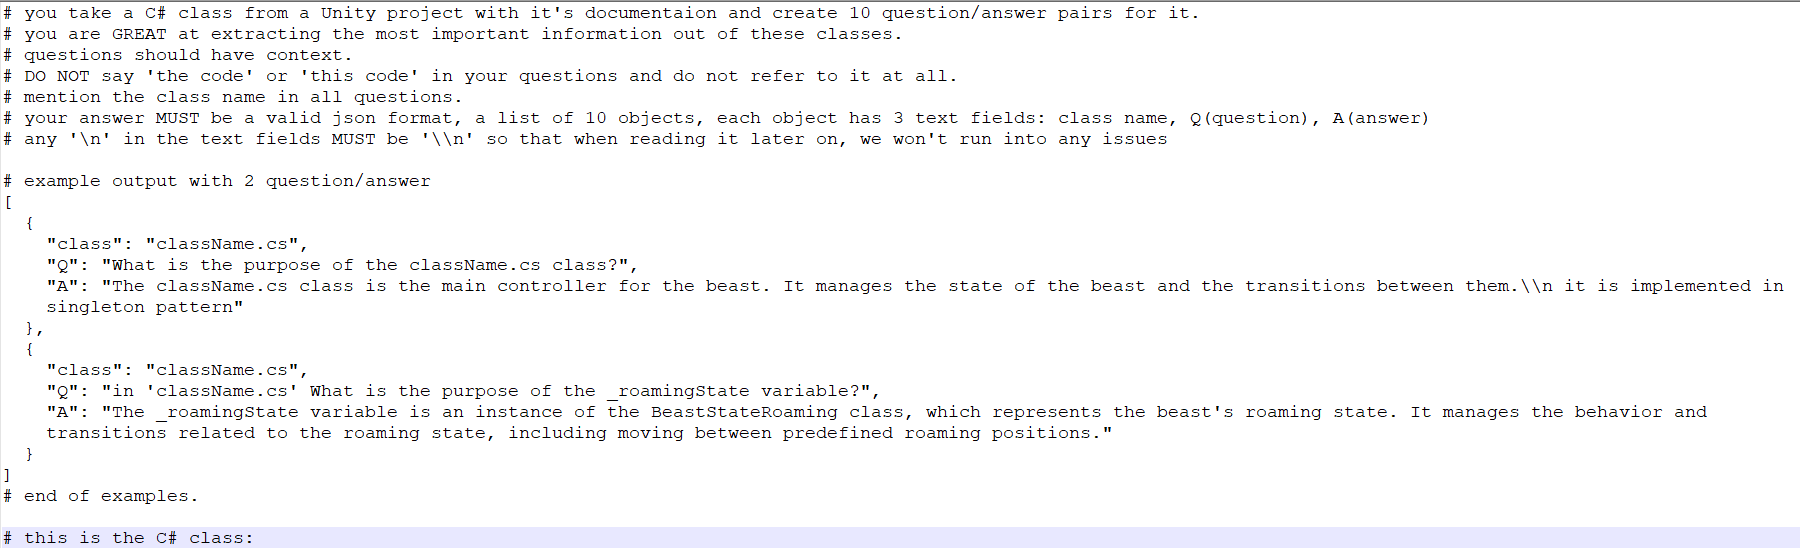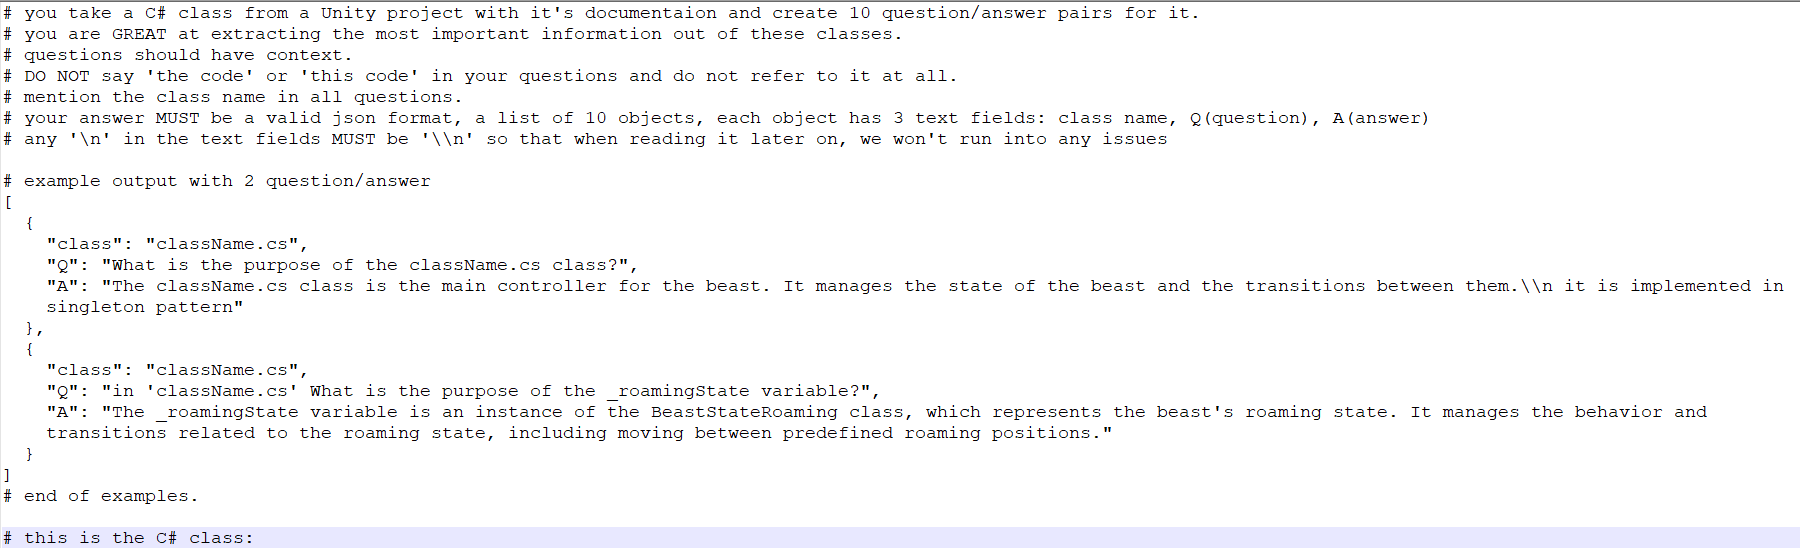)

# **Data Preparation:**
In this example, we are going to fine-tune Mistral on the Enlighten’s codebase which is just a bunch of C# classes. Keep in mind, these raw C# classes can be used to fine-tune base non-instruct models but the resulting model will also be non-instruct and will just complete a document, mostly used for code completion.

> But what we need:


---


we need **instruction-based data in the form of question/answer pairs** so that our model can work/aswer on questions ask about the classes/methods etc. used in codebase.


> What we should do:


To acheive this, we are going to use **a much larger and stronger model to generate our data** based on the code base *synthetically*. Author chose the newly released Google Gemini Pro for this task since it is both free for this use-case and powerful. (Gpt-4 would be the best model but the API is not free).



> Training and Testing dataset

We need two datasets, one for training and one for testing, **both will be synthetically generated by Gemini**. Training data will be a question about the code and its answer. The testing dataset will be in the form of multiple choice questions, it is a question followed by 4 choices and the correct one.

For each C# class, Author generated **20 Q/A** for training and **3 **for testing. 20 training questions were **10 just-code questions** and **10 general questions**. There were about 90 C# classes in total.

Now we are going **to give each class to Gemini and ask it to generate our data, for this, we need our own customized system message**. These are the System messages *Author* engineered.





# System Message Strategy:
1. Tell What to Do or What's purpose
2. Rules/Instrunctions to be followed
3. Response format and its instrunction a.ka few-shot prompting technique (if any)- so that its output is more aligned with what we need
4. Example Oputput (if any)
5. Context (if any)

# System message for 10 just-code questions (Training Data)

> Tell what to do:

 you take a C# class from a Unity project with it's documentaion and create 10 question/answer pairs for it.

> Rules/Instrunctions to be followed:

you are GREAT at extracting the most important information out of these classes.
all questions should ask for code and all answers should be C# code.
questions should have context.
DO NOT say 'the code' or 'this code' in your questions and do not refer to it at all.
mention the class name in all questions.

> Response Format and its instrunction/rules:

your answer MUST be a valid json format, a list of 10 objects, each object has 3 text fields: class name, Q(question), A(answer)
any '\n' in the text fields MUST be '\\n' so that when reading it later on, we won't run into any issues.


> Example Output
#### example output with 2 question/answer
[
  {
    "class": "className.cs",
    "Q": "in 'className.cs' How does the beast check if the player is in sight?",
    "A": " ```csharp\\nVector3 direction = (player.position - new Vector3(0, 0.5f, 0)) - beastTransform.position;\\nif (Physics.Raycast(beastTransform.position, direction, out hit, eyeSightDistance, layerMask)) {\\n  if (hit.collider.CompareTag("Player")) {\\n    return true;\\n  }\\n}\\n``` "
  },
  {
    "class": "className.cs",
    "Q": "What is the code used to calculate the distance between the player and the beast in 'className.cs' ?",
    "A": " ```csharp\\nif (navMeshAgent.remainingDistance > distanceToPlayerThatBeastRuns)\\n    navMeshAgent.speed = Constants.BeastFastSpeed;\\nelse navMeshAgent.speed = normalSpeed;\\n``` "
  }
]
#### end of examples.


> Context

#### this is the C# class:


#System message for 10 general questions (Training Data)
###### you take a C# class from a Unity project with it's documentaion and create 10 question/answer pairs for it.
###### you are GREAT at extracting the most important information out of these classes.
###### questions should have context.
###### DO NOT say 'the code' or 'this code' in your questions and do not refer to it at all.
###### mention the class name in all questions.
###### your answer MUST be a valid json format, a list of 10 objects, each object has 3 text fields: class name, Q(question), A(answer)
###### any '\n' in the text fields MUST be '\\n' so that when reading it later on, we won't run into any issues

###### example output with 2 question/answer
[
  {
    "class": "className.cs",
    "Q": "What is the purpose of the className.cs class?",
    "A": "The className.cs class is the main controller for the beast. It manages the state of the beast and the transitions between them.\\n it is implemented in singleton pattern"
  },
  {
    "class": "className.cs",
    "Q": "in 'className.cs' What is the purpose of the _roamingState variable?",
    "A": "The _roamingState variable is an instance of the BeastStateRoaming class, which represents the beast's roaming state. It manages the behavior and transitions related to the roaming state, including moving between predefined roaming positions."
  }
]
###### end of examples.

###### this is the C# class:

#System message for 3 multiple choice questions (Testing Data)
###### you take a C# class from a Unity project with it's documentaion and create 3 question/answer pairs for it.
###### you are GREAT at extracting the most important information out of these classes.
###### DO NOT say 'the code' or 'this code' in your questions and do not refer to it at all.
###### mention the class name in all questions.
###### your answer MUST be a valid json format, a list of 3 objects, each object has 6 text fields: class name, Question, a,b,c,d,Answer

###### example output with 2 question/answer
[
  {
    "class": "className.cs",
    "Question": "In className.cs what is the purpose of the PlayerManager class?",
    "a": "To control player movement",
    "b": "To manage some player behavior functionality",
    "c": "To handle player combat actions",
    "d": "To store references to key player components",
    "Answer": "b"
  },
  {
    "class": "className.cs",
    "Question": "What does the FarthestPlaceFromPlayer() method do in className.cs?",
    "a": "Finds the farthest destination from the player",
    "b": "Teleports the player",
    "c": "Returns a random destination",
    "d": "Sets the player position",
    "Answer": "a"
  }
]
###### end of examples.

###### this is the C# class:

#At the end,
Author also added some **non-synthetic data** to the training dataset. First Author wrote some general info on the Enlighten project, and then for each class, Author added these:

question: write the “ClassName” class

answer: entire code of ClassName.cs

####DataGenerator.ipynb --- does all magic explained above related with Data Prepration

#Fine Tuning with LoRA (Low Rank Adaptation) Starts from Here

In [5]:
# Name of base model from huggingFace or path to model
base_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
new_model = "EnlightenCodebase_Instruct"

test_path='/content/Learning/fine-tune/Dataset/TestData.csv'
train_path='/content/Learning/fine-tune/Dataset/TrainData.csv'

Install some packages, clone the git repo (just for the dataset), abd import the library

In [2]:
#which captures the stdout/stderr of a cell. By default, %%capture discards these streams. This is a simple way to suppress unwanted output.
%%capture
!git clone --single-branch --branch develop 'https://github.com/vijaykeshri/Learning.git'
!pip install -U bitsandbytes
!pip install transformers==4.39.2
!pip install -U peft
!pip install -U accelerate
!pip install -U trl
!pip install datasets==2.18.0
!pip install sentencepiece

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,HfArgumentParser,TrainingArguments,pipeline, logging
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch
from datasets import load_dataset
from trl import SFTTrainer
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
import re

Before moving further, On elast and imp step to get our Data ready, each **instruct-tuned LLM follows a certain format for its instrunction/response** One of these formats is **ChatML**, this format contains **three parts**, system, user, and assistant.

This is an example of a generated text in ChatML format.
```
<|im_start|>system
Assistant is an intelligent chatbot designed to help users answer their tax related questions.
<|im_end|>
<|im_start|>user
When do I need to file my taxes by?
<|im_end|>
<|im_start|>assistant
In 2023, you will need to file your taxes by April 18th. The date falls after the usual April 15th deadline because April 15th falls on a Saturday in 2023. For more details, see https://www.irs.gov/filing/individuals/when-to-file
<|im_end|>
```



Mistral 7b instruct uses a much simpler format. At first, we have the BOS(begin of sequence) token which is **<s>**, there is **no system message**, and then the **user's prompt goes between [INST] and [/INST]**, then there is the **assistant’s response and at the end, we have the EOS(end of sequence) token </s>**.

This is an example of a generated text in Mistral’s format.
```
<s>[INST] What is your favourite condiment? [/INST]
Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!</s>
```

**So before we start** the fine-tuning, we must change our data to follow this format, Author also added “@Enlighten.” before the instructions **so that it functions like a system message**. Later we’ll also include it at the beginning of the prompts.

#Building the Dataset in ChatML format or Instruct/Response format

In [6]:
# First lets view data using Colab's Interactive feature
from google.colab import data_table

#Traditional way
import pandas as pd
df = pd.read_csv(train_path)
df.head()

,class,Q,A
0,BeastAttack.cs,What is the purpose of the BeastAttack class?,The BeastAttack class controls the beast's att...
1,BeastAttack.cs,What is the purpose of the strength field in t...,The strength field determines the force with w...
2,BeastAttack.cs,What component does the 'attackAudioClip' vari...,The attackAudioClip variable stores an AudioCl...
3,BeastAttack.cs,What does the OnTriggerEnter method do?,The OnTriggerEnter method is called when the B...
4,BeastAttack.cs,"What is the _collider field, and what is its p...",The _collider field is a reference to the Beas...


In [7]:
df[df['class'].str.startswith('Beast')] # Selecting rows based on a prefix in a column

,class,Q,A
0,BeastAttack.cs,What is the purpose of the BeastAttack class?,The BeastAttack class controls the beast's att...
1,BeastAttack.cs,What is the purpose of the strength field in t...,The strength field determines the force with w...
2,BeastAttack.cs,What component does the 'attackAudioClip' vari...,The attackAudioClip variable stores an AudioCl...
3,BeastAttack.cs,What does the OnTriggerEnter method do?,The OnTriggerEnter method is called when the B...
4,BeastAttack.cs,"What is the _collider field, and what is its p...",The _collider field is a reference to the Beas...
...,...,...,...
1815,BeastStateKilling.cs,write the entire class of BeastStateKilling.cs,```csharp\n ﻿using System;\nusing UnityEngine;...
1816,BeastStateOnTarget.cs,write the entire class of BeastStateOnTarget.cs,```csharp\n ﻿using System;\nusing UnityEngine;...
1817,BeastStateRoaming.cs,write the entire class of BeastStateRoaming.cs,```csharp\n ﻿using System;\nusing StarterAsset...
1818,BeastStateScaping.cs,write the entire class of BeastStateScaping.cs,```csharp\n ﻿using System;\n\n/*\n * Beast.Sta...


In [10]:
df['class'].str.startswith('Beast').sum() # Counting the number of rows based on a prefix in a column

189

In [11]:
# Now a modern way using Colab's Interactive Table, just enable it.
data_table.enable_dataframe_formatter()

In [12]:
df

,class,Q,A
0,BeastAttack.cs,What is the purpose of the BeastAttack class?,The BeastAttack class controls the beast's att...
1,BeastAttack.cs,What is the purpose of the strength field in t...,The strength field determines the force with w...
2,BeastAttack.cs,What component does the 'attackAudioClip' vari...,The attackAudioClip variable stores an AudioCl...
3,BeastAttack.cs,What does the OnTriggerEnter method do?,The OnTriggerEnter method is called when the B...
4,BeastAttack.cs,"What is the _collider field, and what is its p...",The _collider field is a reference to the Beas...
...,...,...,...
1905,descriptive,write about the Puzzles in Enlighten,- puzzles are the main part of the game\n- puz...
1906,descriptive,write about the Beast in Enlighten,- the beast is a monster that hunts the player...
1907,descriptive,write about the Main game loop in Enlighten,- player enters a closed environment (like a b...
1908,descriptive,write about the NPC in Enlighten,*Kits:\n- Kits is a cute girl with a cat mask ...
